# setup

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import re
import pickle
import random
from typing import Sequence, Tuple
from tempfile import mkdtemp
from datetime import datetime

import optuna
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.metrics import auc, roc_auc_score, accuracy_score, f1_score, precision_score, recall_score

from catboost import CatBoostClassifier, Pool

pd.set_option('display.max_rows', 100)

In [9]:
from src.io import csv_loader_factory, PickleLoader
from src.preprocessing import TextCleaner
from src.embeddings import W2VEmbedder
from src.eval.metrics import compute_metrics

In [17]:
list( {
        'eval_metric': 'AUC',
        'early_stopping_rounds': 50,
        'verbose': 0,
        'grow_policy': 1,
        'min_data_in_leaf':1,
        'learning_rate': 1,
        'reg_lambda': 1,
        'max_depth': 1,
        'num_leaves': 1,
    }.keys())

['eval_metric',
 'early_stopping_rounds',
 'verbose',
 'grow_policy',
 'min_data_in_leaf',
 'learning_rate',
 'reg_lambda',
 'max_depth',
 'num_leaves']

# optuna res

In [5]:
name = 'test_study_20220108_0154.pkl'
path = os.path.join('./opt_studies/', name)

with open(path, 'rb') as p:
    study = pickle.load(p)

study_df = study.trials_dataframe()
study_df['is_best'] = 0
study_df.loc[[t.number for t in study.best_trials], 'is_best'] = 1

run = len(study_df)
completed = len(study_df[study_df['state']=='COMPLETE'])

print(f'run: {run}, compleated: {completed} ({round(completed/run, 3)})')
study_df[study_df['is_best']==1].sort_values('values_0', ascending=False)

run: 1559, compleated: 1415 (0.908)


,number,values_0,values_1,datetime_start,datetime_complete,duration,params_alpha,params_epochs,params_grow_policy,params_latinize,...,params_ns_exponent,params_num_leaves,params_reg_lambda,params_sg,params_to_lower,params_vector_size,system_attrs_nsga2:generation,system_attrs_nsga2:parents,state,is_best
1250,1250,0.616245,0.028436,2022-01-08 11:58:40.560339,2022-01-08 11:59:06.278594,0 days 00:00:25.718255,0.091,10,Lossguide,False,...,0.60,18,7,1,False,100,19,"[1002, 709]",COMPLETE,1
398,398,0.599375,0.066667,2022-01-08 09:22:44.769109,2022-01-08 09:23:32.319982,0 days 00:00:47.550873,0.081,5,Lossguide,True,...,0.40,24,7,0,False,250,5,"[311, 174]",COMPLETE,1
505,505,0.597256,0.111111,2022-01-08 09:40:16.583625,2022-01-08 09:40:51.973959,0 days 00:00:35.390334,0.061,8,Lossguide,True,...,0.30,12,9,1,False,250,7,"[357, 372]",COMPLETE,1
949,949,0.582098,0.122271,2022-01-08 11:08:28.751767,2022-01-08 11:09:01.042834,0 days 00:00:32.291067,0.061,5,Lossguide,True,...,0.90,24,7,1,False,250,14,"[659, 829]",COMPLETE,1
546,546,0.576745,0.134529,2022-01-08 09:51:23.325951,2022-01-08 09:52:19.067864,0 days 00:00:55.741913,0.071,9,Lossguide,True,...,-0.05,6,5,0,False,750,8,"[328, 467]",COMPLETE,1
556,556,0.554620,0.155738,2022-01-08 09:52:28.328678,2022-01-08 09:52:45.362703,0 days 00:00:17.034025,0.101,10,Lossguide,False,...,0.40,24,5,1,False,250,8,"[206, 454]",COMPLETE,1
1486,1486,0.535899,0.160000,2022-01-08 12:50:00.386456,2022-01-08 12:50:25.723644,0 days 00:00:25.337188,0.051,7,Lossguide,True,...,0.85,24,3,1,False,50,23,"[433, 425]",COMPLETE,1
328,328,0.520158,0.168224,2022-01-08 08:38:08.263067,2022-01-08 08:38:31.035954,0 days 00:00:22.772887,0.071,9,Lossguide,True,...,-0.05,18,3,1,False,100,4,"[157, 180]",COMPLETE,1
610,610,0.504063,0.170213,2022-01-08 10:04:03.464676,2022-01-08 10:04:42.311106,0 days 00:00:38.846430,0.101,7,Lossguide,False,...,0.40,36,7,0,False,250,9,"[206, 593]",COMPLETE,1


<AxesSubplot:xlabel='auc', ylabel='f1'>

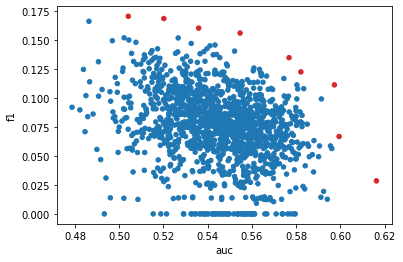

In [6]:
dfp = study_df[study_df['state']=='COMPLETE'][['values_0', 'values_1', 'is_best']].rename({'values_0': 'auc', 'values_1': 'f1'}, axis=1)

color_map ={
    1: 'tab:red',
    0: 'tab:blue'
}
colors = dfp['is_best'].replace(color_map)
dfp.plot.scatter(x='auc', y='f1', c=colors)


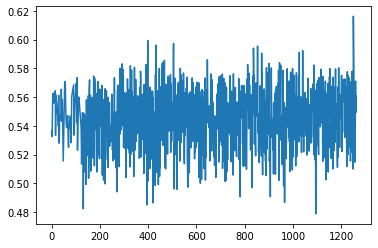

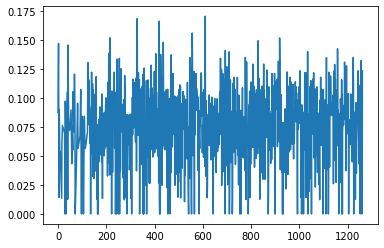

In [98]:
dfp = study_df[study_df['state']=='COMPLETE'][['number', 'values_0', 'values_1']].rename({'values_0': 'auc', 'values_1': 'f1'}, axis=1)

dfp['auc'].plot()
plt.show()
dfp['f1'].plot()
plt.show()

In [103]:
imp_auc = optuna.importance.get_param_importances(study, target=lambda t: t.values[0])
imp_f1 = optuna.importance.get_param_importances(study, target=lambda t: t.values[1])

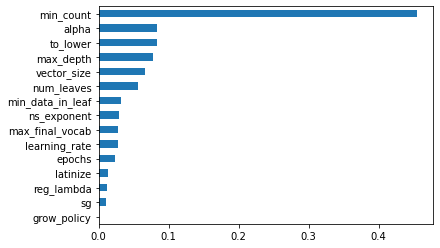

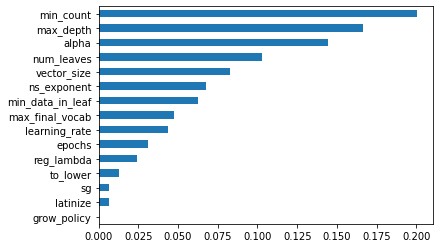

In [111]:
pd.Series(imp_auc).sort_values().plot.barh()
plt.show()

pd.Series(imp_f1).sort_values().plot.barh()
plt.show()

**Insights**:  

Text cleaner
* `params_latinize` minor impact -> can be defaulted to **False**
* `params_to_lower` lowers both **auc** and **f1** -> default to **False**

W2V Encoder
* positive corr of `epochs` with **f1** -> increase max number of `epoch` ~20
* !**auc** and **f1** has almost perfect negative corellation with respect to number of `epoch`
* increase `params_alpha` significant increasing trend of **f1** -> max should be increased to 0.2
* `params_max_final_vocab` should be between 10-15k
* `params_min_count`:  
    * **auc** is maximized in 100-125 range
    * **f1** max around 50-60, negative corr
* `params_ns_exponent` best metric values between -0.2 and 0.2, above 0.2 both metrics decrease
* `params_sg` minor impact on average metrics -> fix at 0
* `params_vector_size`  
Best **auc** values match lowest **f1** values. Similarly in the oher side
    * **auc** best values between 400 and 750
    * **f1** best values between 300 and 600

Learner
* `params_learning_rate` slight increasing trend of **f1** -> max should be increased to 0.2
* ?`params_grow_policy` other than *Lossguide* failed
* `params_max_depth`: negative corr with **auc** and positive with **f1**
Best **auc** at 3, best **f1** at 13
* `params_min_data_in_leaf` both metrics has positive corr -> should be increased to ~200
* `params_num_leaves` significant impact, similar to max_depth
Best **auc** at 5, best **f1** at 35
* `params_reg_lambda` minor impact, should be between 3 and 7, can be fixed to 5/6
Best **auc** at 3, best **f1** at 7

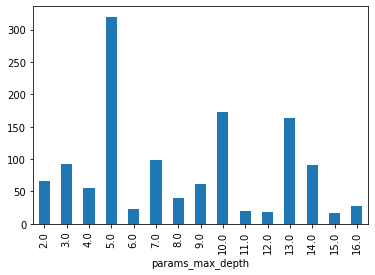

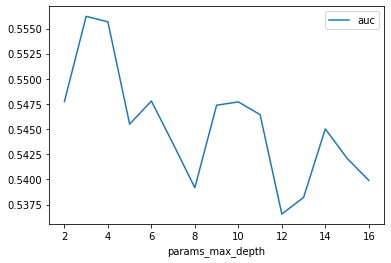

<AxesSubplot:xlabel='params_max_depth'>

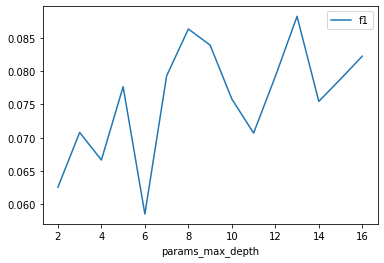

In [112]:
dfg = study_df.groupby('params_max_depth').agg(
    size=('params_grow_policy', 'size'),
    auc=('values_0', 'median'),
    f1=('values_1' ,'median')
)

dfg['size'].plot(kind='bar')
plt.show()
dfg[['auc']].plot()
plt.show()
dfg[['f1']].plot()

# train best model

In [7]:
study_df.loc[505, :]

number                                                  505
values_0                                           0.597256
values_1                                           0.111111
datetime_start                   2022-01-08 09:40:16.583625
datetime_complete                2022-01-08 09:40:51.973959
duration                             0 days 00:00:35.390334
params_alpha                                          0.061
params_epochs                                             8
params_grow_policy                                Lossguide
params_latinize                                        True
params_learning_rate                                  0.046
params_max_depth                                          5
params_max_final_vocab                                11600
params_min_count                                        110
params_min_data_in_leaf                                  41
params_ns_exponent                                      0.3
params_num_leaves                       

In [68]:
import pickle
from datetime import datetime

import numpy as np
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score, f1_score

from src.preproc import tokenize
from src.io import csv_loader_factory
from src.preprocessing import TextCleaner
from src.embeddings import W2VEmbedder



def objective():
    # clean
    cleaner_params = {
        'latinize': False,
        'to_lower': False,
    }
    cleaner = TextCleaner(**cleaner_params)
    train_clean = cleaner.fit_transform(train_raw)
    test_clean = cleaner.transform(test_raw)
    
    # tokenize
    train_tokens, train_label_tok = tokenize(train_clean, train_label)
    test_tokens, test_label_tok = tokenize(test_clean, test_label)
    
    # vectorize
    emb_params = {
        'vector_size': 250,
        'sg': 1,
        'max_final_vocab': 11600,
        'min_count': 110,
        'ns_exponent': 0.3,
        'alpha': 0.061,
        'epochs': 8,        
        'workers': 1,#16,
    }
    emb = W2VEmbedder(**emb_params)
    emb.fit(train_tokens)
    
    train_w2v = emb.transform(train_tokens)
    test_w2v = emb.transform(test_tokens)
    
    # fit model
    cb_params = {
        'eval_metric': 'AUC',
        'early_stopping_rounds': 50,
        'verbose': 0,
        'grow_policy': 'Lossguide',
        'min_data_in_leaf': 41,
        'learning_rate': 0.046,
        'reg_lambda': 9,
        'max_depth': 5,
        'num_leaves': 12,
        'random_state': 12345,
    }

    cb = CatBoostClassifier(**cb_params)
    cb.fit(X=train_w2v, y=train_label_tok, eval_set=(test_w2v, test_label_tok))

    # eval model
    proba_train = cb.predict_proba(train_w2v)[:, 1]
    proba_test = cb.predict_proba(test_w2v)[:, 1]
    
    tresh = np.quantile(proba_train, np.mean(train_label_tok))
    pred_test = (proba_test<tresh).astype(int)
    
    auc = roc_auc_score(test_label_tok, proba_test)
    f1 = f1_score(test_label_tok, pred_test)
    
    
    display(compute_metrics((train_label_tok, proba_train), (test_label_tok, proba_test)))

    print(f'|mean pred |{round(np.mean(proba_train), 6)}|{round(np.mean(proba_test), 6)}|')
    pd.Series(proba_test).plot.hist()
    
    return emb


loader = csv_loader_factory('poleval')
data = loader.load()

train_raw = data.loc[data['dataset']=='train', 'text_raw']
train_label = data.loc[data['dataset']=='train', 'tag']
test_raw = data.loc[data['dataset']=='test', 'text_raw']
test_label = data.loc[data['dataset']=='test', 'tag']


INFO:2022-01-09 08:34:09:io:loading from csv: ./data/poleval19.csv
INFO:2022-01-09 08:34:09:io:loaded 11039 rows


INFO:2022-01-09 08:34:41:gensim.models.word2vec:collecting all words and their counts
INFO:2022-01-09 08:34:41:gensim.models.word2vec:PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO:2022-01-09 08:34:41:gensim.models.word2vec:PROGRESS: at sentence #10000, processed 104799 words, keeping 25170 word types
INFO:2022-01-09 08:34:41:gensim.models.word2vec:collected 25205 word types from a corpus of 105046 raw words and 10026 sentences
INFO:2022-01-09 08:34:41:gensim.utils:Word2Vec lifecycle event {'msg': 'max_final_vocab=11600 and min_count=110 resulted in calc_min_count=2, effective_min_count=110', 'datetime': '2022-01-09T08:34:41.048198', 'gensim': '4.1.2', 'python': '3.8.8 (tags/v3.8.8:024d805, Feb 19 2021, 13:18:16) [MSC v.1928 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.19041-SP0', 'event': 'prepare_vocab'}
INFO:2022-01-09 08:34:41:gensim.models.word2vec:Creating a fresh vocabulary
INFO:2022-01-09 08:34:41:gensim.utils:Word2Vec lifecycle event {'msg': 'effectiv

,train,test
AUC,0.572329,0.540467
Accuracy,0.857969,0.825826
F1,0.048128,0.054348
Precision,0.055641,0.100000
Recall,0.042403,0.037313


|mean pred |0.338521|0.338624|


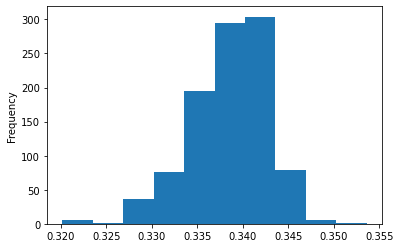

In [71]:

results = objective()

In [46]:
len(results.model.wv)

78

In [55]:
len(results.model.wv)

78

In [53]:
results.model.wv.most_similar('chyba')

[('No', 0.9501962065696716),
 ('teraz', 0.9483229517936707),
 ('tylko', 0.9473258852958679),
 ('po', 0.939659059047699),
 ('ze', 0.9370262622833252),
 ('jeszcze', 0.9363874793052673),
 ('przez', 0.9316632151603699),
 ('już', 0.9290154576301575),
 ('W', 0.9285308122634888),
 ('mi', 0.9281338453292847)]

In [56]:
results.model.wv.most_similar('chyba')

[('teraz', 0.9598919153213501),
 ('po', 0.9558937549591064),
 ('od', 0.9522861242294312),
 ('ze', 0.9462188482284546),
 ('Na', 0.9461850523948669),
 ('sobie', 0.9404746890068054),
 ('tylko', 0.9402301907539368),
 ('już', 0.9387791156768799),
 ('przez', 0.9375009536743164),
 ('jeszcze', 0.9367812275886536)]

In [52]:
sorted(results.model.wv.index_to_key)

['A',
 'Ale',
 'Bo',
 'Co',
 'I',
 'Ja',
 'Jak',
 'Na',
 'Nie',
 'No',
 'Tak',
 'To',
 'Ty',
 'W',
 'Z',
 'a',
 'ale',
 'bardzo',
 'bez',
 'bo',
 'by',
 'być',
 'był',
 'było',
 'będzie',
 'chyba',
 'co',
 'coś',
 'czy',
 'dla',
 'do',
 'go',
 'i',
 'ja',
 'jak',
 'jest',
 'jeszcze',
 'już',
 'kto',
 'ktoś',
 'ma',
 'mam',
 'mi',
 'mnie',
 'może',
 'można',
 'na',
 'nic',
 'nie',
 'o',
 'od',
 'po',
 'przez',
 'się',
 'sobie',
 'są',
 'tak',
 'taki',
 'takie',
 'tam',
 'te',
 'tego',
 'ten',
 'teraz',
 'też',
 'to',
 'tu',
 'ty',
 'tylko',
 'tym',
 'w',
 'wiem',
 'więc',
 'z',
 'za',
 'ze',
 'że',
 'żeby']

In [57]:
sorted(results.model.wv.index_to_key)

['A',
 'Ale',
 'Bo',
 'Co',
 'I',
 'Ja',
 'Jak',
 'Na',
 'Nie',
 'No',
 'Tak',
 'To',
 'Ty',
 'W',
 'Z',
 'a',
 'ale',
 'bardzo',
 'bez',
 'bo',
 'by',
 'być',
 'był',
 'było',
 'będzie',
 'chyba',
 'co',
 'coś',
 'czy',
 'dla',
 'do',
 'go',
 'i',
 'ja',
 'jak',
 'jest',
 'jeszcze',
 'już',
 'kto',
 'ktoś',
 'ma',
 'mam',
 'mi',
 'mnie',
 'może',
 'można',
 'na',
 'nic',
 'nie',
 'o',
 'od',
 'po',
 'przez',
 'się',
 'sobie',
 'są',
 'tak',
 'taki',
 'takie',
 'tam',
 'te',
 'tego',
 'ten',
 'teraz',
 'też',
 'to',
 'tu',
 'ty',
 'tylko',
 'tym',
 'w',
 'wiem',
 'więc',
 'z',
 'za',
 'ze',
 'że',
 'żeby']